### ---Public : 0.88625, Private : 0.89248---
### Strong baseline : 0.89266
### Medium baseline : 1.36937
### Simple baseline : 2.04826

In [ ]:
!pip install transformers==4.5.0

In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# For data preprocess
import numpy as np
import pandas as pd
import csv
import math

# Warm up
from transformers import get_linear_schedule_with_warmup

# For plotting
import matplotlib.pyplot as plt

myseed = 15 # set a random seed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
df = pd.read_csv('/kaggle/input/ml2021spring-hw1/covid.train.csv')
test_df = pd.read_csv('/kaggle/input/ml2021spring-hw1/covid.test.csv')

x = df[df.columns[1:94]]
y = df[df.columns[94]]

df.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

bestfeatures = SelectKBest(score_func=f_regression, k=14)
fit = bestfeatures.fit(x,y)
cols = bestfeatures.get_support(indices=True)

df = df.iloc[:,cols]

df.head()

,WI,cli,ili,hh_cmnty_cli,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2
0,0.0,0.814610,0.771356,25.648907,43.279629,19.586492,0.838995,0.807767,25.679101,43.622728,20.151838,0.897802,0.887893,26.060544
1,0.0,0.838995,0.807767,25.679101,43.622728,20.151838,0.897802,0.887893,26.060544,43.604229,20.704935,0.972842,0.965496,25.754087
2,0.0,0.897802,0.887893,26.060544,43.604229,20.704935,0.972842,0.965496,25.754087,42.665766,21.292911,0.955306,0.963079,25.947015
3,0.0,0.972842,0.965496,25.754087,42.665766,21.292911,0.955306,0.963079,25.947015,42.972417,21.166656,0.947513,0.968764,26.350501
4,0.0,0.955306,0.963079,25.947015,42.972417,21.166656,0.947513,0.968764,26.350501,42.907472,19.896607,0.883833,0.893020,26.480624


In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 

print(featureScores.nlargest(15,'Score')) # Print 15 best features

                 Specs          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191


In [ ]:
# Pandas to Numpy
x = df[df.columns].values
y = y.values

# Numpy to Tensor
x = torch.Tensor(x).cuda()
y = torch.Tensor(y).cuda()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.15)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
network = Net()
network.cuda()

Net(
  (fc1): Linear(in_features=14, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.15, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# Split into train/test
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=0.1, random_state=31)

In [ ]:
epochs = 10000
batch_size = 256

step = len(x_train)//batch_size
warm_up_ratio = 0.1
total_step = step*epochs
optimizer = torch.optim.RAdam(network.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warm_up_ratio * total_step, num_training_steps = total_step)

train_losses = []
test_losses = []

# Early Stopping parameters
ES_patience = 500
ES_counter = 0 
best_epoch = 0
best_loss = np.inf

In [ ]:
def train(epoch):
  network.train()
  for i in range(step):
    optimizer.zero_grad()
    pred = network(x_train[batch_size*i:batch_size*(i+1)])
    loss = F.mse_loss(pred.view(-1), x_test[batch_size*i:batch_size*(i+1)])
    loss.backward()
    optimizer.step()
    scheduler.step()

  train_losses.append(loss.item())

In [ ]:
def test(epoch):
  global best_epoch, best_loss, ES_counter

  network.eval()
  with torch.no_grad():
    pred = network(y_train)
    loss = F.mse_loss(pred.view(-1), y_test)
    
  # Early Stopping
  if best_loss > loss:
    ES_counter, best_epoch, best_loss = 0, epoch, loss
    # Save best model
    torch.save(network.state_dict(), '/kaggle/model.pth')
    print('Saving model (epoch = {:4d}, MSE loss = {:.4f})'.format(epoch, loss))
  else:
    ES_counter += 1
    if ES_counter == ES_patience:
      print('---Early Stopping--- (Best epoch = {:4d}, Best MSE loss = {:.4f})'.format(best_epoch, best_loss))
  # Early Stopping

  test_losses.append(loss.item())

In [ ]:
for epoch in range(1, epochs+1):
  train(epoch)
  test(epoch)
  if ES_counter == ES_patience:
    break

Saving model (epoch =    1, MSE loss = 317.6799)
Saving model (epoch =  192, MSE loss = 317.5733)
Saving model (epoch =  193, MSE loss = 317.3950)
Saving model (epoch =  194, MSE loss = 317.2142)
Saving model (epoch =  195, MSE loss = 317.0391)
Saving model (epoch =  196, MSE loss = 316.8634)
Saving model (epoch =  197, MSE loss = 316.6871)
Saving model (epoch =  198, MSE loss = 316.5012)
Saving model (epoch =  199, MSE loss = 316.3207)
Saving model (epoch =  200, MSE loss = 316.1386)
Saving model (epoch =  201, MSE loss = 315.9550)
Saving model (epoch =  202, MSE loss = 315.7711)
Saving model (epoch =  203, MSE loss = 315.5949)
Saving model (epoch =  204, MSE loss = 315.4198)
Saving model (epoch =  205, MSE loss = 315.2306)
Saving model (epoch =  206, MSE loss = 315.0491)
Saving model (epoch =  207, MSE loss = 314.8717)
Saving model (epoch =  208, MSE loss = 314.6794)
Saving model (epoch =  209, MSE loss = 314.4935)
Saving model (epoch =  210, MSE loss = 314.3037)
Saving model (epoch 

Text(0, 0.5, 'Loss')

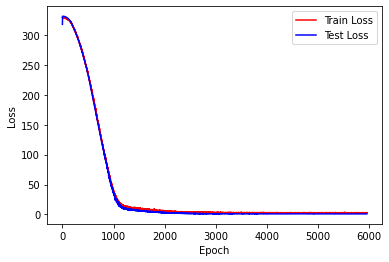

In [ ]:
fig = plt.figure()
plt.plot(range(len(train_losses)), train_losses, color='red')
plt.plot(range(len(train_losses)), test_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
best_network = Net().cuda()
network_state_dict = torch.load('/kaggle/model.pth')
best_network.load_state_dict(network_state_dict)

<All keys matched successfully>

In [ ]:
best_network.eval()

test_df = test_df.iloc[:,cols]

test_X = test_df.values #Pandas to Numpy
test_X = torch.Tensor(test_X).cuda() #Numpy to Tensor
pred = best_network(test_X)

In [ ]:
import csv

print('Saving results')
with open('/kaggle/working/submission.csv', "w") as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(pred):
        writer.writerow([i, p.item()])

Saving results
